In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [7]:
!pip install qiskit-aer

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 9.5/9.5 MB 66.1 MB/s eta 0:00:00


In [2]:
audio_path = 'archive/Piano_Notes/piano-eb_D#_major.wav'

In [10]:
y,sr = librosa.load(audio_path)
duration = librosa.get_duration(y = y, sr = sr)
samples = len(y)

In [4]:
n_fft = 2048 # window length for short forier transform
hop_length = 512 # hop difference between each window

In [5]:
samples

33968

In [6]:
y, _ = librosa.effects.trim(y, top_db = 10)
stft = librosa.stft(y)
chromagram = librosa.feature.chroma_stft(S = np.abs(stft), sr = sr)

In [7]:
chromagram.shape

(12, 24)

In [7]:
def get_chromagram(audio_file):
    y,sr = librosa.load(audio_file)
    y, _ = librosa.effects.trim(y, top_db = 10)
    stft = librosa.stft(y)
    chromagram = librosa.feature.chroma_stft(S = np.abs(stft), sr = sr)
    return chromagram

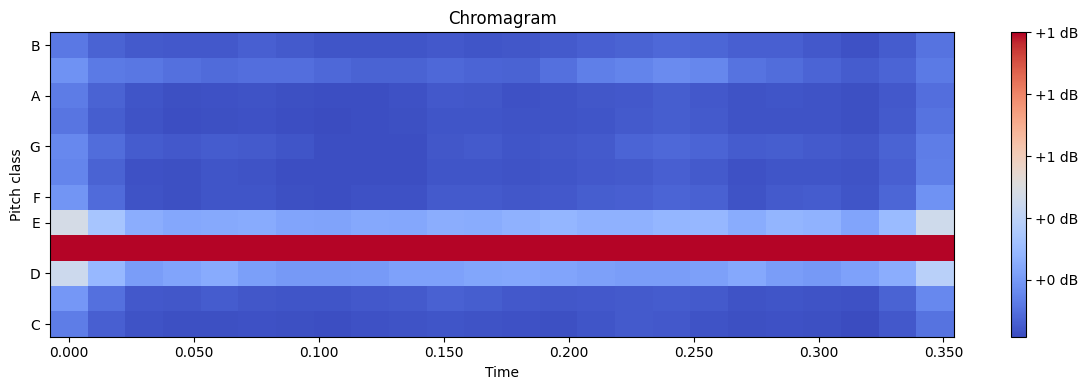

In [11]:
chroma = get_chromagram(audio_path)

plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, sr=samples, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [2]:
audio_path = 'archive/Piano_Notes/piano-eb_D#_major.wav'

In [10]:
chromagram = get_chromagram(audio_path)

In [11]:
prominant_pitch = np.argmax(chromagram[:,21])

In [12]:
pitch_classes = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

In [13]:
pitch_name = pitch_classes[prominant_pitch]
pitch_name

'D#'

In [14]:
# Designing the Circuit
import qiskit
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.parameter import Parameter
import numpy as np

In [15]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit import Parameter
 
angle = Parameter("angle2")  # undefined number
 
# Create and optimize circuit once
qc = QuantumCircuit(1)
qc.ry(angle, 0)

qc = generate_preset_pass_manager(optimization_level=3, basis_gates=["u", "cx"]).run(qc)
 
qc.draw(output = 'text')

┌───────────────┐
q: ┤ U(angle2,0,0) ├
   └───────────────┘

In [16]:
def vqc(n_qubits, n_layers, n_features):
    
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    
    qc = QuantumCircuit(qr, cr, name = 'vqc')

    # using angle encoding
    # REASONS: direct maping of classical data
    #           using continuous variable to represent feature, to preserve mor eof the original
    for i in range(n_features):
        angle = Parameter(f'feature{i}')
        qc.ry(angle, qr[i % n_qubits])   # reusing the same qubits to code multiple features

    # for the number of circuit layers we want to implement
    for layer in range(n_layers):
        for i in range(n_qubits):
            theta = Parameter(f'theta_{layer}_{i}')
            phi = Parameter(f'phi_{layer}_{i}')
            lam = Parameter(f'lambda_{layer}_{i}')
            qc.u(theta, phi, lam, qr[i])

        for i in range(n_qubits -1):
            qc.cx(qr[i], qr[i+1])

        if n_qubits > 1: 
            qc.cx(qr[n_qubits -1], qr[0])

    qc.measure(qr,cr)
    return qc

In [17]:
n_qubits = 4
n_layers = 2
n_features = 12
circuit = vqc(n_qubits, n_layers, n_features)

In [18]:
circuit.draw(output="text")

┌──────────────┐┌──────────────┐ ┌──────────────┐»
q_0: ┤ Ry(feature0) ├┤ Ry(feature4) ├─┤ Ry(feature8) ├»
     ├──────────────┤├──────────────┤ ├──────────────┤»
q_1: ┤ Ry(feature1) ├┤ Ry(feature5) ├─┤ Ry(feature9) ├»
     ├──────────────┤├──────────────┤┌┴──────────────┤»
q_2: ┤ Ry(feature2) ├┤ Ry(feature6) ├┤ Ry(feature10) ├»
     ├──────────────┤├──────────────┤├───────────────┤»
q_3: ┤ Ry(feature3) ├┤ Ry(feature7) ├┤ Ry(feature11) ├»
     └──────────────┘└──────────────┘└───────────────┘»
c: 4/═════════════════════════════════════════════════»
                                                      »
«     ┌─────────────────────────────────┐          »
«q_0: ┤ U(theta_0_0,phi_0_0,lambda_0_0) ├──■───────»
«     ├─────────────────────────────────┤┌─┴─┐     »
«q_1: ┤ U(theta_0_1,phi_0_1,lambda_0_1) ├┤ X ├──■──»
«     ├─────────────────────────────────┤└───┘┌─┴─┐»
«q_2: ┤ U(theta_0_2,phi_0_2,lambda_0_2) ├─────┤ X ├»
«     ├─────────────────────────────────┤     └───┘»
«q_3: ┤ U(theta_0_3,phi_0_3,lambda_0_3) ├──────────»
«     └─────────────────────────────────┘          »
«c: 4/═════════════════════════════════════════════»
«                                                  »
«                                        ┌───┐»
«q_0: ───────────────────────────────────┤ X ├»
«     ┌─────────────────────────────────┐└─┬─┘»
«q_1: ┤ U(theta_1_1,phi_1_1,lambda_1_1) ├──┼──»
«     └─────────────────────────────────┘  │  »
«q_2: ─────────────────■───────────────────┼──»
«                    ┌─┴─┐                 │  »
«q_3: ───────────────┤ X ├─────────────────■──»
«                    └───┘                    »
«c: 4/════════════════════════════════════════»
«                                             »
«     ┌─────────────────────────────────┐                  ┌───┐   ┌─┐   
«q_0: ┤ U(theta_1_0,phi_1_0,lambda_1_0) ├──■───────────────┤ X ├───┤M├───
«     └─────────────────────────────────┘┌─┴─┐          ┌─┐└─┬─┘   └╥┘   
«q_1: ───────────────────────────────────┤ X ├──■───────┤M├──┼──────╫────
«     ┌─────────────────────────────────┐└───┘┌─┴─┐     └╥┘  │  ┌─┐ ║    
«q_2: ┤ U(theta_1_2,phi_1_2,lambda_1_2) ├─────┤ X ├──■───╫───┼──┤M├─╫────
«     ├─────────────────────────────────┤     └───┘┌─┴─┐ ║   │  └╥┘ ║ ┌─┐
«q_3: ┤ U(theta_1_3,phi_1_3,lambda_1_3) ├──────────┤ X ├─╫───■───╫──╫─┤M├
«     └─────────────────────────────────┘          └───┘ ║       ║  ║ └╥┘
«c: 4/═══════════════════════════════════════════════════╩═══════╩══╩══╩═
«                                                        1       2  0  3

In [19]:
circuit.parameters

ParameterView([Parameter(feature0), Parameter(feature1), Parameter(feature10), Parameter(feature11), Parameter(feature2), Parameter(feature3), Parameter(feature4), Parameter(feature5), Parameter(feature6), Parameter(feature7), Parameter(feature8), Parameter(feature9), Parameter(lambda_0_0), Parameter(lambda_0_1), Parameter(lambda_0_2), Parameter(lambda_0_3), Parameter(lambda_1_0), Parameter(lambda_1_1), Parameter(lambda_1_2), Parameter(lambda_1_3), Parameter(phi_0_0), Parameter(phi_0_1), Parameter(phi_0_2), Parameter(phi_0_3), Parameter(phi_1_0), Parameter(phi_1_1), Parameter(phi_1_2), Parameter(phi_1_3), Parameter(theta_0_0), Parameter(theta_0_1), Parameter(theta_0_2), Parameter(theta_0_3), Parameter(theta_1_0), Parameter(theta_1_1), Parameter(theta_1_2), Parameter(theta_1_3)])

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import torch
import torch.nn as nn

class QNNClassifier(nn.Module):
    def __init__(self, n_qubits, n_layers, n_features, num_classes):
        super(QNNClassifier, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_features = n_features
        self.num_classes = num_classes
        self.simulator = Aer().get_backend()

        # Create the parameterized quantum circuit
        self.vqc_circuit = vqc(n_qubits, n_layers, n_features)
        self.num_params = len(self.vqc_circuit.parameters) - n_features # Number of trainable parameters
        self.params = nn.Parameter(torch.rand(self.num_params) * 2 * torch.pi)

        self.fc = nn.Linear(2**n_qubits, num_classes)

    def forward(self, x):
        qc = self.vqc_circuit.assign_parameters({}) # Start with no parameters assigned
        param_dict = {}

        # Assign feature parameters
        for i in range(self.n_features):
            param_name = f'feature{i}'
            if param_name in qc.parameters_set:
                param_dict[qc.parameters[qc.parameters.index(Parameter(param_name))]] = x[:, i % self.n_qubits]

        # Assign trainable parameters
        param_index = 0
        for param in qc.parameters:
            if param.name.startswith('theta_') or param.name.startswith('phi_') or param.name.startswith('lambda_'):
                param_dict[param] = self.params[param_index]
                param_index += 1

        qc_bound = qc.assign_parameters(param_dict)
        qc_transpiled = transpile(qc_bound, self.simulator) # Transpile for the backend
        job = self.simulator.run(qc_transpiled, shots=1024)
        result = job.result().get_counts(qc_transpiled)

        output_vector = [result.get(bin(i)[2:].zfill(self.n_qubits), 0) for i in range(2**self.n_qubits)]
        output_tensor = torch.tensor(output_vector, dtype=torch.float32)
        output = self.fc(output_tensor)
        return output